+ [Download dataset](https://www.kaggle.com/c/dogs-vs-cats/data?select=train.zip)
+ Image augmentation
+ Pretrain model
+ Cross entropy loss
+ Confusion matrix

In [1]:
import glob, random, math, time
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import cv2

print(torch.cuda.is_available(), torch.backends.cudnn.is_available(), torch.cuda.get_device_name(0))
device = torch.device('cuda')
print(device)

True True NVIDIA GeForce GTX 1650 with Max-Q Design
cuda


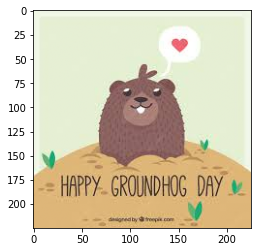

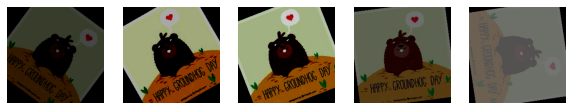

torch.Size([5, 3, 225, 225])
torch.Size([5, 3, 225, 225])


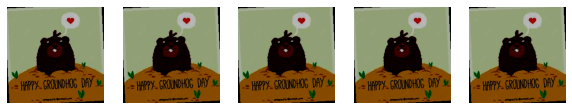

In [2]:
pic = plt.imread("./groundhog.jpeg")/255
plt.imshow(pic)
plt.show()
pic = torch.Tensor(pic)
pic = pic.permute(2,0,1)

transform = transforms.Compose([
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            transforms.ColorJitter(brightness=0.8, contrast=0.8), # 1-v,1+v
            transforms.RandomRotation(90),
            lambda x:x,
            ]) # input torch.tensor, torch.float32, channel first # can operate on an image (3,w,h) or a image Batch (Bz,3,w,h)

plt.figure(figsize=(10,5))
for i in range(5):
    newPic = transform( pic )
    plt.subplot(1,5,i+1)
    plt.imshow( newPic.permute(1,2,0) )
    plt.axis('off')
plt.show()

batch = torch.stack([pic,pic,pic,pic,pic])
print(batch.shape)
newBatch = transform(batch)
print(newBatch.shape)
plt.figure(figsize=(10,5))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow( newBatch[i].permute(1,2,0) )
    plt.axis('off')
plt.show()

In [3]:
class MyDataset(Dataset):
    def __init__(self, pathList, device):
        self.pathList = pathList
        self.device = device
    def __len__(self):
        return len(self.pathList)
    def __getitem__(self, index):
        x = cv2.imread( self.pathList[index] )/255.
        x = cv2.resize(x, (224,224))
        x = torch.Tensor(x).to(self.device)
        x = x.permute(2,0,1)
        x = self.aug(x)
        y = torch.Tensor([0 if "dog" in self.pathList[index] else 1]).type(torch.int64).to(self.device) # no one-hot
        return x,y
    def aug(self, x):
        transform = transforms.Compose([\
            transforms.ColorJitter(brightness=0.2, contrast=0.2), # 1-v,1+v
        ])
        return transform(x)

pathList = glob.glob("train/*")
random.shuffle(pathList)
trainPathList, valPathList = pathList[:int(len(pathList)*0.8)], pathList[int(len(pathList)*0.8):]
trainDataset, valDataset = MyDataset(trainPathList,device), MyDataset(valPathList,device)
print( len(trainDataset), len(valDataset) )
print( trainDataset[0][0].shape, trainDataset[0][1] )

20000 5000
torch.Size([3, 224, 224]) tensor([1], device='cuda:0')


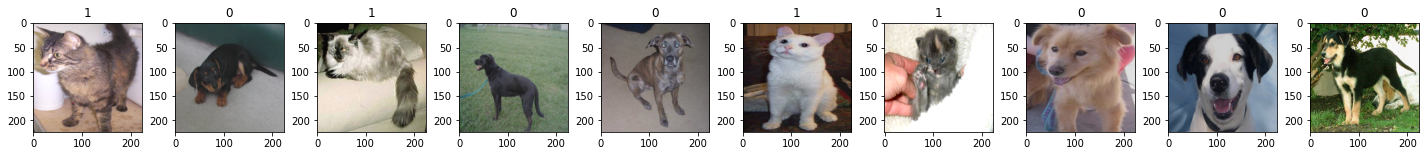

In [4]:
plt.figure(figsize=(25,2))
for i,(X,y) in enumerate(trainDataset):
    if i<10:
        XLast = (X.permute(1,2,0).cpu().numpy()*255).astype(int)
        plt.subplot(1,10,i+1)
        plt.imshow(XLast[:,:,::-1])
        plt.title( int(y) )
    else:
        break
plt.show()

In [5]:
batch_size = 16
trainDataLoader = DataLoader(trainDataset, batch_size=batch_size, pin_memory=False)
valDataLoader   = DataLoader(valDataset, batch_size=batch_size, pin_memory=False)
print( len(trainDataLoader), len(valDataLoader) )

1250 313


In [6]:
# 224 -(bn1)-> 112 -(L1)> 56 -(L2)> 28 -(L3)> 14 -(L4)> 7 
resnet18 = models.resnet18()
D = resnet18.state_dict()
for i,key in enumerate(D):
    print( i, key, D[key].shape )

0 conv1.weight torch.Size([64, 3, 7, 7])
1 bn1.weight torch.Size([64])
2 bn1.bias torch.Size([64])
3 bn1.running_mean torch.Size([64])
4 bn1.running_var torch.Size([64])
5 bn1.num_batches_tracked torch.Size([])
6 layer1.0.conv1.weight torch.Size([64, 64, 3, 3])
7 layer1.0.bn1.weight torch.Size([64])
8 layer1.0.bn1.bias torch.Size([64])
9 layer1.0.bn1.running_mean torch.Size([64])
10 layer1.0.bn1.running_var torch.Size([64])
11 layer1.0.bn1.num_batches_tracked torch.Size([])
12 layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
13 layer1.0.bn2.weight torch.Size([64])
14 layer1.0.bn2.bias torch.Size([64])
15 layer1.0.bn2.running_mean torch.Size([64])
16 layer1.0.bn2.running_var torch.Size([64])
17 layer1.0.bn2.num_batches_tracked torch.Size([])
18 layer1.1.conv1.weight torch.Size([64, 64, 3, 3])
19 layer1.1.bn1.weight torch.Size([64])
20 layer1.1.bn1.bias torch.Size([64])
21 layer1.1.bn1.running_mean torch.Size([64])
22 layer1.1.bn1.running_var torch.Size([64])
23 layer1.1.bn1.num_batches_

In [7]:
resnet18Part = models._utils.IntermediateLayerGetter(resnet18, {'layer1':'out1', 'layer3':'out2'}) # submodule can be called but not module
out = resnet18Part(torch.rand(1,3,224,224))
print( type(out), out.keys() )
print([(key,out[key].shape) for key in out])

<class 'collections.OrderedDict'> odict_keys(['out1', 'out2'])
[('out1', torch.Size([1, 64, 56, 56])), ('out2', torch.Size([1, 256, 14, 14]))]


/home/james/miniconda3/envs/test/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [8]:
def getResnet():
    resnet18 = models.resnet18(pretrained=False).to(device)
    for p in resnet18.parameters():
        p.requires_grad = False
    resnet18Part = models._utils.IntermediateLayerGetter(resnet18, {'layer2':'out2'})
    for p in resnet18Part.parameters():
        p.requires_grad = False
    return resnet18Part

class myModel(nn.Module):
    def __init__(self, useResnetBackbone=True):
        super().__init__()
        self.conv1   = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu1   = nn.ReLU()
        self.maxpool1= nn.MaxPool2d(2)
        self.conv2   = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu2   = nn.ReLU()
        self.maxpool2= nn.MaxPool2d(2)
        self.conv3   = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu3   = nn.ReLU()
        self.maxpool3= nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.dense1  = nn.Linear(28*28*64, 64)
        self.dense2  = nn.Linear(64, 64)
        self.dense3  = nn.Linear(64, 2)
        self.useResnetBackbone = useResnetBackbone
        if useResnetBackbone:
            resnet18 = models.resnet18(pretrained=False).to(device)
            self.resnet18Part = models._utils.IntermediateLayerGetter(resnet18, {'layer2':'out2'})
        # don't do softmax, since nn.functional.CrossEntropyLoss will do
    def forward(self, x): # (bz,3,224,224)
        if self.useResnetBackbone:
            rout = self.resnet18Part(x)
            rout2 = rout['out2'] # (bz,128,28,28)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x) # (bz,64,112,112)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x) # (bz,64,56,56)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x) # (bz,64,28,28)
        if True and self.useResnetBackbone:
            with torch.no_grad():
                #x = torch.cat([y,rout2], axis=1) # (bz,192,28,28) # cannot use concat or the gradient by loss.backward() will error
                x = x + rout2[:,:64,:,:] + rout2[:,:64,:,:] # (bz,64,28,28)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return x

model = myModel(True).to(device)
print( sum( parameter.numel() for parameter in model.parameters() ) ) # type: torch.nn.parameter.Parameter
model(torch.rand(1,3,224,224).to('cuda'))

3974338


tensor([[0.0145, 1.0177]], device='cuda:0', grad_fn=<AddmmBackward>)

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_func = nn.CrossEntropyLoss()

def training(model, trainDataLoader, valDataLoader, epochs, optimizer, loss_func, history):
    trainDataNum = len(trainDataLoader)*trainDataLoader.batch_size
    valDataNum = len(valDataLoader)*valDataLoader.batch_size
    for ep in range(epochs):
        print(f"Epoch: {ep+1}/{epochs}")
        # training loop
        trainLoss, trainAcc = 0.0, 0.0
        for i,(X,y) in enumerate(trainDataLoader):
            # loss
            optimizer.zero_grad()
            pred = model(X)
            loss = loss_func(pred,y.squeeze()) # pred:torch.float32(Bz,Prob), true:torch.int64(Bz) # dataLoader will let y be (Bz,1)
            loss.backward()
            optimizer.step()
            trainLoss += loss.item() / trainDataNum
            # acc
            ypred = pred.argmax(axis=1)
            trainAcc += int((ypred==y.squeeze()).sum()) / trainDataNum
            #
            print(f"\rbatch={i+1}/{len(trainDataLoader)}, trainLoss={trainLoss:.5f}, trainAcc={trainAcc:.5f}", end="")
        history["trainLossL"].append(trainLoss)
        history["trainAccL"].append(trainAcc)
        print()
        # validation loop
        with torch.no_grad():
            valLoss, valAcc = 0.0, 0.0
            for i,(X,y) in enumerate(valDataLoader):
                # loss
                pred = model(X)
                loss = loss_func(pred,y.squeeze())
                valLoss += loss.item() / valDataNum
                # acc
                ypred = pred.argmax(axis=1)
                valAcc += int((ypred==y.squeeze()).sum()) / valDataNum
                #
                print(f"\rbatch={i+1}/{len(valDataLoader)}, valLoss={valLoss:.5f}, valAcc={valAcc:.5f}", end="")
            history["valLossL"].append(valLoss)
            history["valAccL"].append(valAcc)
            print()
    return history

history = {"trainLossL":[], "trainAccL":[], "valLossL":[], "valAccL":[]}

In [10]:
epochs = 3
history = training(model, trainDataLoader, valDataLoader, epochs, optimizer, loss_func, history)

Epoch: 1/3
batch=1250/1250, trainLoss=0.04077, trainAcc=0.66420
batch=313/313, valLoss=0.03437, valAcc=0.72384
Epoch: 2/3
batch=1250/1250, trainLoss=0.03319, trainAcc=0.73530
batch=313/313, valLoss=0.03437, valAcc=0.71426
Epoch: 3/3
batch=1250/1250, trainLoss=0.02909, trainAcc=0.78440
batch=313/313, valLoss=0.04024, valAcc=0.70268


In [11]:
#epochs = 1
#history = training(model, trainDataLoader, valDataLoader, epochs, optimizer, loss_func, history)

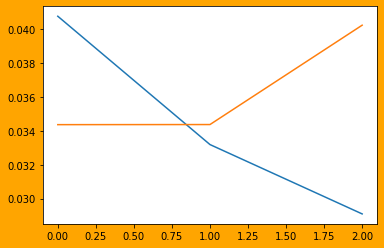

In [12]:
ax = plt.figure()
ax.set_facecolor("orange")
plt.plot(history["trainLossL"])
plt.plot(history["valLossL"])
plt.show()

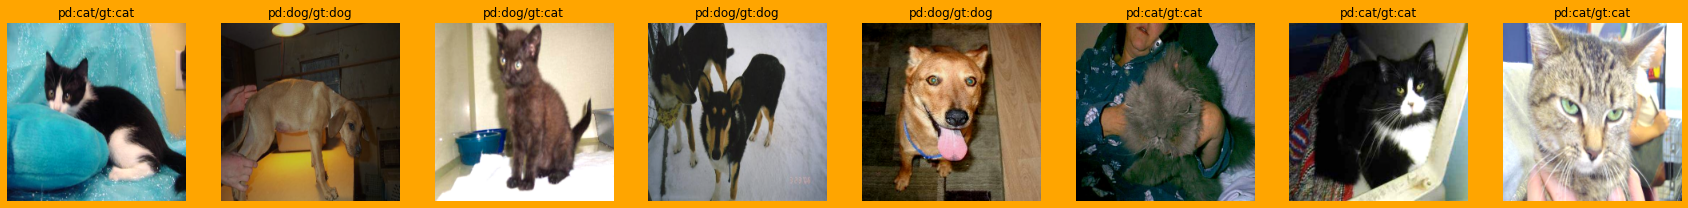

[[2052, 1092], [388, 1468]]


In [21]:
confusion = [[0,0], [0,0]] # [[d->d,c->d],[d->c,c->c]] 
with torch.no_grad():
    for i,(X,y) in enumerate(valDataLoader):
        pred = model(X)
        ypred = pred.argmax(axis=1)
        if i==0:
            XLast = (X.permute(0,2,3,1).cpu().numpy()*255).astype(int)
            ax = plt.figure(figsize=(30,2*3))
            ax.set_facecolor("orange")
            for j in range(8):
                plt.subplot(1,8,j+1)
                plt.title(f"pd:{'dog' if int(ypred[j])==0 else 'cat'}/gt:{'dog' if int(y[j])==0 else 'cat'}")
                plt.imshow( XLast[j,:,:,::-1] )
                plt.axis('off')
            plt.show()
        for yp,yt in zip(ypred.cpu().numpy(),y.squeeze()):
            confusion[yp][yt]+=1
print(confusion)

In [23]:
torch.save(model.state_dict(), "model_state_dict.pt")